In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pylab as py

## Modelando odipolo magnético

In [2]:
#criando grid. Atemporal
xmin = -3000
xmax = 3000
nx = 200

ymin = -3000
ymax = 3000
ny = 200

x = np.linspace(xmin, xmax, nx, endpoint=True) # metros
y = np.linspace(ymin, ymax, ny, endpoint=True) # metros
z = -10.0 # metros
X,Y = np.meshgrid(x,y)

In [3]:
#funções cedidas pelo professor Rodrigo Bijani
from funcoes_campo import *

In [4]:
#campo magnético
#localização
xc = 330.0                                  # metros
yc = 330.0                                  # metros
zc = 800.0                                  # metros (z é positivo para baixo)
raio = 50.0                                 # metros
inc,dec = -23.0, -33.0                      # inclinacao, declinacao magnetica

bx = dipolo_bx(X,Y,z,[xc,yc,zc,raio], 2.5, inc,dec)
by = dipolo_by(X,Y,z,[xc,yc,zc,raio], 2.5, inc,dec)
bz = dipolo_bz(X,Y,z,[xc,yc,zc,raio], 2.5, inc,dec)

# Simulação do campo Regional:
F = 23500          # nT
I,D = -25.0, -35.0 # direcao do campo do dipolo la no nucleo da terra
Fx,Fy,Fz = F_regional(F,I,D)

# Projecoes Cartesianas  o campo total (o que de fato é aferido pelo magnetometro):
Bx = bx+Fx
By = by+Fy
Bz = bz+Fz

Bat = (Bx**2 + By**2 + Bz**2)**(0.5)
Bt = (bx**2 + by**2 + bz**2)**(0.5)-F

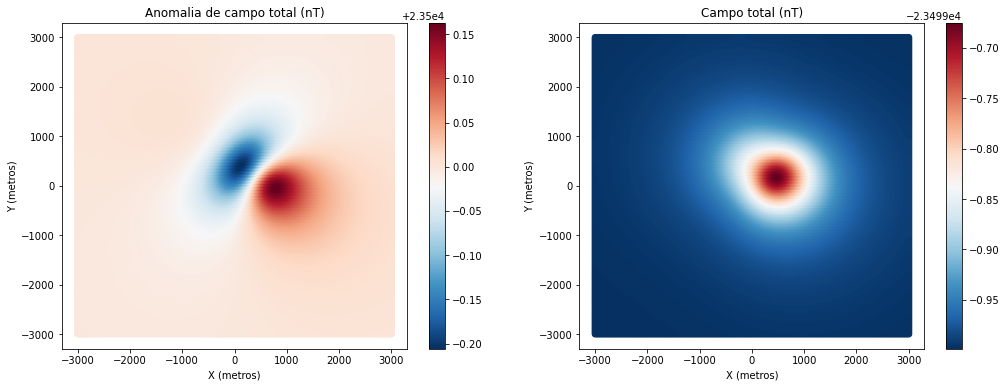

In [5]:
py.rcParams['figure.figsize'] = (17., 12/2) #Redimensiona a figura

plt.subplot(1, 2, 1)
plt.scatter(X,Y,c=Bat,cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Anomalia de campo total (nT)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(X,Y,c=Bt,cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Campo total (nT)')
plt.colorbar()


plt.savefig("imagens/campoTotal.jpeg")
plt.show()

## Modelando a variação diurna

In [6]:
F = 23500.0 # Campo regional (IGRF no Rj, por exemplo) em nT

def variacaoDiurna(h,F,vB,i=0,f=1):
    if 6. <= h <= 18.:
        return F + vB * np.sin((np.pi/12.0) * (h-6.0) ) + random.normalvariate(i, f)
    else:
        return F + random.normalvariate(i,f)

# preparando dados para um plot teste
vB = 30    # amplitude da variacao diurna em nT
hora = np.linspace(0.0, 24.0, 1000, endpoint=True)
B_diurno = []
for h in hora:
    B = variacaoDiurna(h,F,vB)
    B_diurno.append(B)

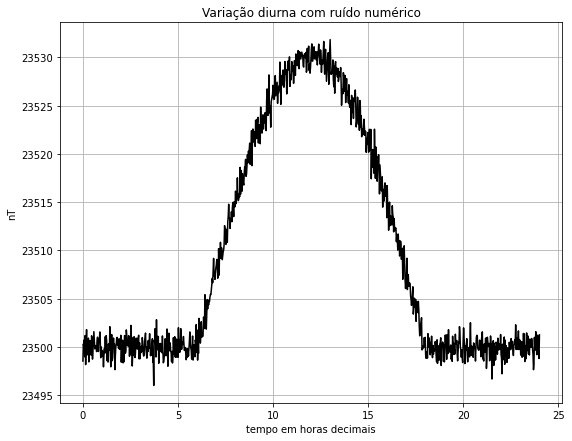

In [7]:
plt.figure(figsize=(9,7))
plt.plot(hora, B_diurno, 'k-',)
plt.xlabel('tempo em horas decimais')
plt.title("Variação diurna com ruído numérico")
plt.grid()
plt.ylabel('nT')

plt.savefig("imagens/variacaoDiurna_exemplo.jpeg")

plt.show()

## Simulação da aquisição. Dados em função do tempo

> $B_{móvel} = B_{regional} + B_{dipolo}  + B_{variaçãoDiurna}$

> $B_{base} = B_{regional} + B_{variaçãoDiurna}$

In [8]:
#criando grid de observações em função do tempo
passos_x = 200
passos_y = 100

#matrizes com os dados. primeira linha é x, segunda é y, terceira é B medido e quarta é o tempo
magnetometroMovel_xyBt = [[],[],[],[]]
magnetometroBase_Bt = [[],[]]           #fixado em (-3000,-3000)
B_t = []

B_regional = F

t = 6 #horas da manhã
print("Hora de início:",t)

for x in range(xmin,xmax+1,passos_x):
    for y in range(ymin,ymax+1,passos_y):
        t += 0.009 #espaçamento temporal entre cada ponto
        
        B_variacao = variacaoDiurna(t,0,vB)

        #dados magnetometro movel
        bx = dipolo_bx(x,y,z,[xc,yc,zc,raio], 2.5, inc,dec)
        by = dipolo_by(x,y,z,[xc,yc,zc,raio], 2.5, inc,dec)
        bz = dipolo_bz(x,y,z,[xc,yc,zc,raio], 2.5, inc,dec)

        Bx = bx+Fx
        By = by+Fy
        Bz = bz+Fz
        Bt = (Bx**2 + By**2 + Bz**2)**(0.5)
        
        magnetometroMovel_xyBt[0] += [x]
        magnetometroMovel_xyBt[1] += [y]
        magnetometroMovel_xyBt[2] += [Bt+variacaoDiurna(t,0,vB,f=0.01)]
        magnetometroMovel_xyBt[3] += [t]
        
        #dados magnetometro base
        magnetometroBase_Bt[0] += [B_regional+variacaoDiurna(t,0,vB,f=0.01)]
        magnetometroBase_Bt[1] += [t]
        
        # salvando dado do dipolo para depois calcular o residuo
        B_t.append(((bx**2 + by**2 + bz**2)**(0.5)))
        
    # simulando o movimento de um veiculo, então o carro faz linhas paralelas S/N "indo" e depois N/S "voltando"
    yminX = ymin
    ymin,ymax,passos_y = ymax,yminX,-passos_y
        
print("Hora de término:",t)

Hora de início: 6
Hora de término: 22.88400000000064


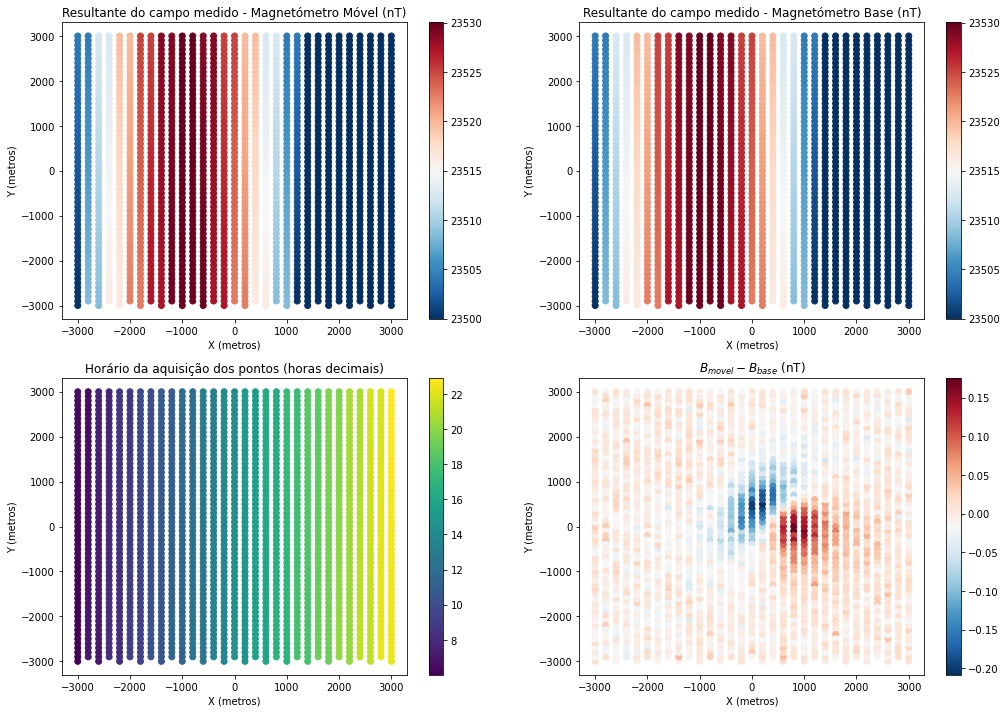

In [9]:
# vizualizacao do grid de observacoes em função do tempo
py.rcParams['figure.figsize'] = (17.0, 12.0) #Redimensiona a figura

plt.subplot(2, 2, 1)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=magnetometroMovel_xyBt[2],cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Resultante do campo medido - Magnetómetro Móvel (nT)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=magnetometroBase_Bt[0],cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Resultante do campo medido - Magnetómetro Base (nT)')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=magnetometroMovel_xyBt[3])
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Horário da aquisição dos pontos (horas decimais)')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=np.array(magnetometroMovel_xyBt[2])-np.array(magnetometroBase_Bt[0]),cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('$B_{movel} - B_{base}$ (nT)')
plt.colorbar()
plt.savefig("imagens/resultadoAquisicao.jpeg")
plt.show()

## Redução da Variação Diurna

> $B_{reduçãoVariaçãoDiurna} = B_{móvel} - {\Delta} = B_{movel} - (B_{base} - B_{mediaMensal})$

In [10]:
media_mensal = F

#redução
dadoReduzidoVariacaoDiurna_xyBt = np.copy(magnetometroMovel_xyBt)
dadoReduzidoVariacaoDiurna_xyBt[2] = magnetometroMovel_xyBt[2] - (np.array(magnetometroBase_Bt[0])-media_mensal)

residuoVariacaoDiurna = dadoReduzidoVariacaoDiurna_xyBt[2] - np.array(B_t)

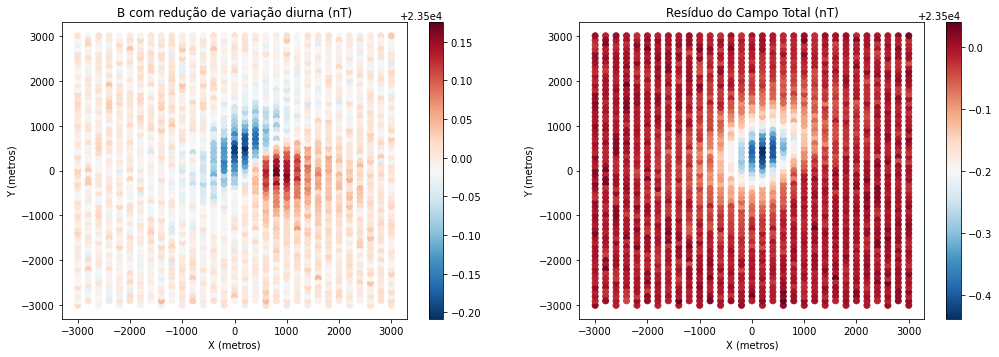

In [11]:
py.rcParams['figure.figsize'] = (17.0, 12.0) #Redimensiona a figura

plt.subplot(2, 2, 1)
plt.scatter(dadoReduzidoVariacaoDiurna_xyBt[0],dadoReduzidoVariacaoDiurna_xyBt[1],c=dadoReduzidoVariacaoDiurna_xyBt[2],cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('B com redução de variação diurna (nT)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.scatter(dadoReduzidoVariacaoDiurna_xyBt[0],dadoReduzidoVariacaoDiurna_xyBt[1],c=residuoVariacaoDiurna,cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Resíduo do Campo Total (nT)')
plt.colorbar()
plt.savefig("imagens/reducaoVariacaoDiurna.jpeg")
plt.show()

## Redução do campo geomagnético utilizando IGRF

> $B_{reduçãoIGRF} = B_{móvel} - B_{IGRF}(x,y)$

In [12]:
#extrapolação
IGRF = F

#reducao
dadoReduzidoIGRF_xyBt = np.copy(dadoReduzidoVariacaoDiurna_xyBt)
dadoReduzidoIGRF_xyBt[2] = dadoReduzidoVariacaoDiurna_xyBt[2]- IGRF

residuoIGRF = np.array(B_t) - dadoReduzidoIGRF_xyBt[2]

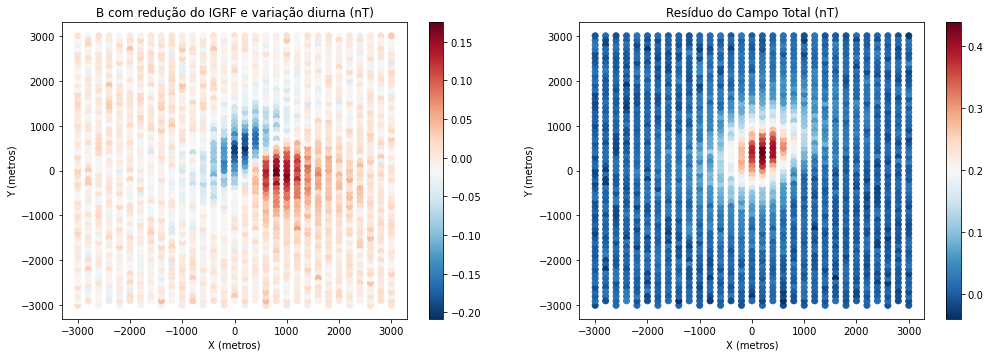

In [13]:
py.rcParams['figure.figsize'] = (17.0, 12.0) #Redimensiona a figura

plt.subplot(2, 2, 1)
plt.scatter(dadoReduzidoIGRF_xyBt[0],dadoReduzidoIGRF_xyBt[1],c=dadoReduzidoIGRF_xyBt[2], cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('B com redução do IGRF e variação diurna (nT)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.scatter(dadoReduzidoIGRF_xyBt[0],dadoReduzidoIGRF_xyBt[1],c=residuoIGRF,cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Resíduo do Campo Total (nT)')
plt.colorbar()
plt.savefig("imagens/reducaoIGRF.jpeg")
plt.show()